# Product Performance & ABC Analysis

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Load processed data
df = pd.read_csv('/content/drive/MyDrive/GlobalSuperstore_Project/data/processed/fully_processed.csv')

In [28]:
# Product performance analysis
product_performance = df.groupby(['Product ID', 'Product Name', 'Category', 'Sub-Category']).agg({
    'Sales': ['sum', 'count', 'mean'],
    'Profit': ['sum', 'mean'],
    'Quantity': 'sum',
    'Discount': 'mean'
}).round(2)

product_performance.columns = ['Total_Sales', 'Transaction_Count', 'Avg_Sale',
                               'Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount']

In [37]:
# Calculate metrics
# Handle division by zero for Profit_Margin: if Total_Sales is 0, Profit_Margin should be 0.
product_performance['Profit_Margin'] = np.where(
    product_performance['Total_Sales'] == 0,
    0,
    (product_performance['Total_Profit'] / product_performance['Total_Sales']) * 100
)
product_performance['Sales_per_Transaction'] = (product_performance['Total_Sales'] /
                                                 product_performance['Transaction_Count'])

In [30]:
# ABC Analysis (Pareto Principle)
product_performance = product_performance.sort_values('Total_Sales', ascending=False)
product_performance['Cumulative_Sales'] = product_performance['Total_Sales'].cumsum()
product_performance['Cumulative_Percentage'] = (product_performance['Cumulative_Sales'] /
                                                 product_performance['Total_Sales'].sum()) * 100

In [31]:
# Classify products
def abc_classify(row):
    if row['Cumulative_Percentage'] <= 80:
        return 'A - High Value'
    elif row['Cumulative_Percentage'] <= 95:
        return 'B - Medium Value'
    else:
        return 'C - Low Value'

product_performance['ABC_Class'] = product_performance.apply(abc_classify, axis=1)

In [32]:
# XYZ Analysis for demand variability
product_performance['CoV'] = df.groupby('Product ID')['Sales'].std() / df.groupby('Product ID')['Sales'].mean()
product_performance['CoV'] = product_performance['CoV'].fillna(0)

def xyz_classify(row):
    if row['CoV'] <= 0.1:
        return 'X - Stable Demand'
    elif row['CoV'] <= 0.5:
        return 'Y - Moderate Variability'
    else:
        return 'Z - Erratic Demand'

product_performance['XYZ_Class'] = product_performance.apply(xyz_classify, axis=1)

In [33]:
# Combine ABC-XYZ matrix
product_performance['ABC_XYZ_Matrix'] = product_performance['ABC_Class'].str[:1] + product_performance['XYZ_Class'].str[:1]


In [34]:
# Save product analysis
product_performance.to_csv('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/product_analysis.csv')

In [35]:
# Generate insights
abc_summary = product_performance.reset_index().groupby('ABC_Class').agg({
    'Product ID': 'count',
    'Total_Sales': 'sum',
    'Total_Profit': 'sum'
}).round(2)

abc_summary['Percentage_of_Products'] = (abc_summary['Product ID'] / abc_summary['Product ID'].sum()) * 100
abc_summary['Percentage_of_Sales'] = (abc_summary['Total_Sales'] / abc_summary['Total_Sales'].sum()) * 100

print("ABC Analysis Summary:")
print(abc_summary)

ABC Analysis Summary:
                  Product ID  Total_Sales  Total_Profit  \
ABC_Class                                                 
A - High Value          3074       444.24       8055.39   
B - Medium Value        2913        83.35       6609.19   
C - Low Value           4781        27.77       7998.61   

                  Percentage_of_Products  Percentage_of_Sales  
ABC_Class                                                      
A - High Value                 28.547548            79.991357  
B - Medium Value               27.052377            15.008283  
C - Low Value                  44.400074             5.000360  


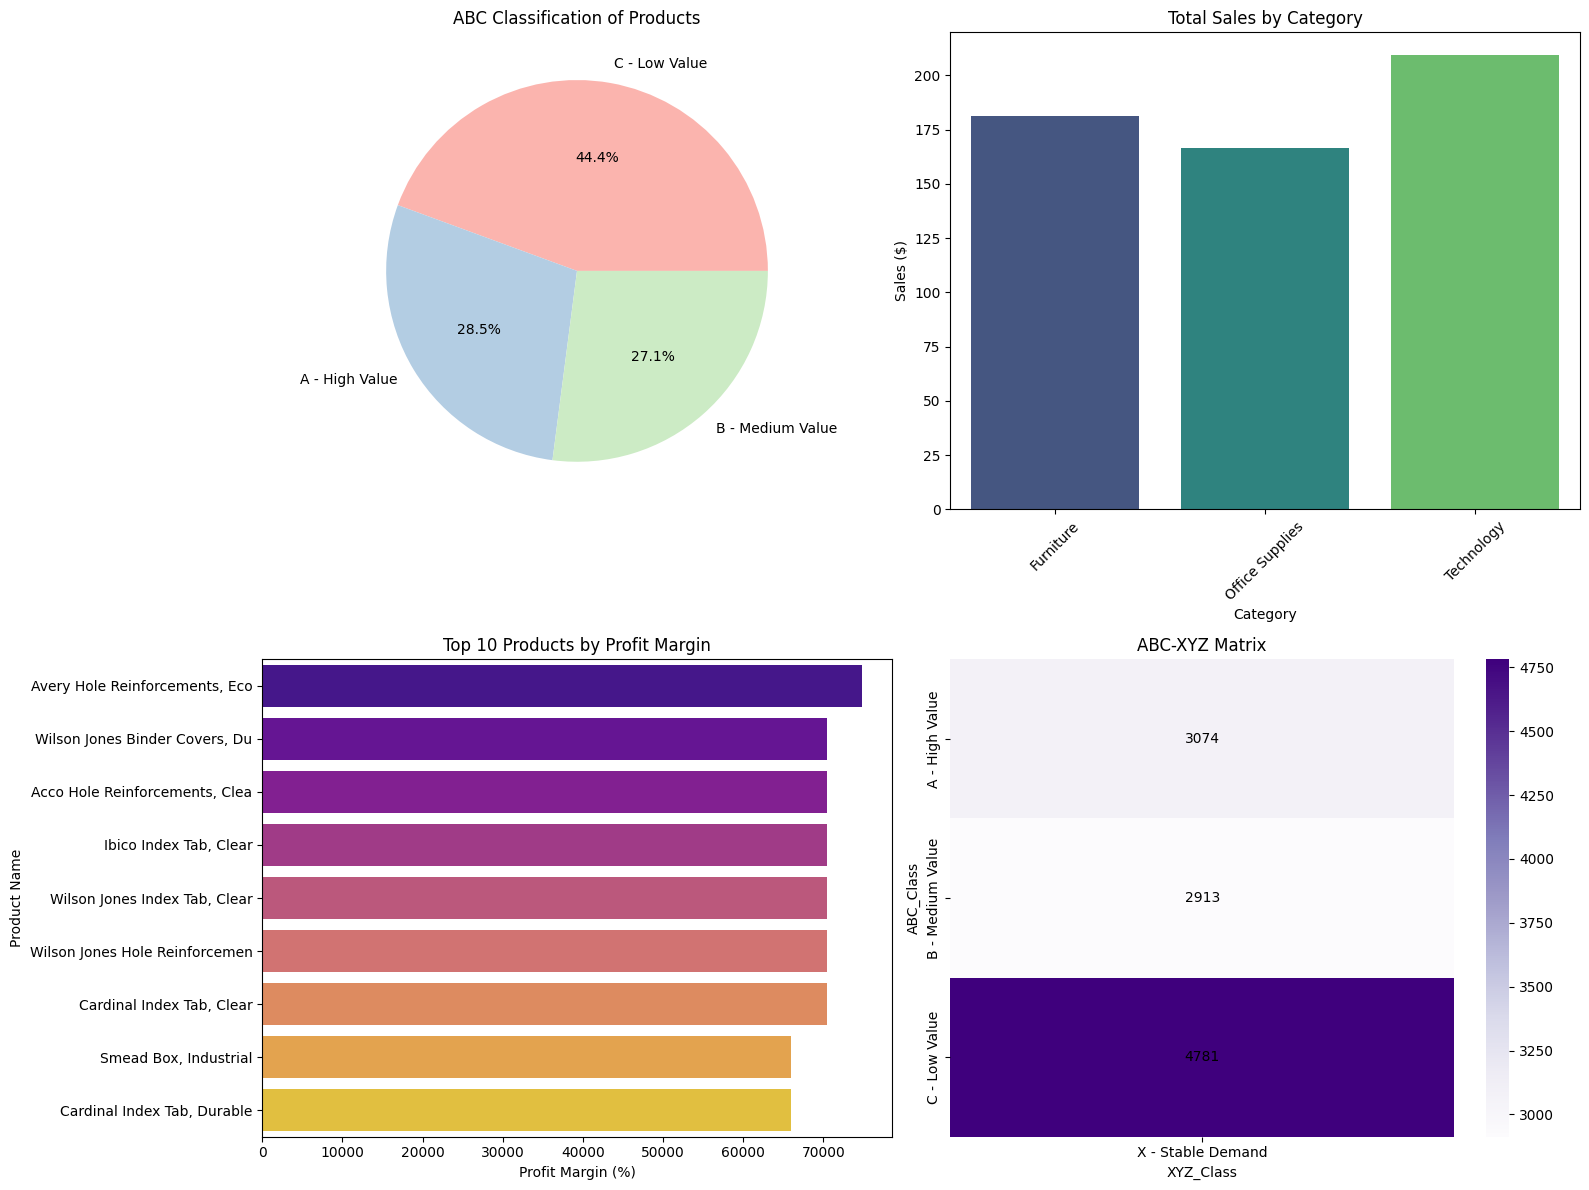

Product analysis completed!


In [43]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ABC Classification
abc_counts = product_performance['ABC_Class'].value_counts()
colors_pie = plt.cm.Pastel1.colors # Using a pastel color map for pie chart
axes[0,0].pie(abc_counts.values, labels=abc_counts.index, autopct='%1.1f%%', colors=colors_pie)
axes[0,0].set_title('ABC Classification of Products')

# 2. Sales by Category
category_sales = df.groupby('Category')['Sales'].sum()
sns.barplot(x=category_sales.index, y=category_sales.values, ax=axes[0,1], palette='viridis', hue=category_sales.index, legend=False) # Using seaborn barplot with viridis palette
axes[0,1].set_title('Total Sales by Category')
axes[0,1].set_ylabel('Sales ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Top 10 Products by Profit Margin
top_margin = product_performance.nlargest(10, 'Profit_Margin')
sns.barplot(x=top_margin['Profit_Margin'], y=top_margin.index.get_level_values('Product Name').str[:30], ax=axes[1,0], palette='plasma', hue=top_margin.index.get_level_values('Product Name').str[:30], legend=False) # Using seaborn barplot with plasma palette
axes[1,0].set_title('Top 10 Products by Profit Margin')
axes[1,0].set_xlabel('Profit Margin (%)')

# 4. ABC-XYZ Matrix Heatmap
matrix_data = pd.crosstab(product_performance['ABC_Class'], product_performance['XYZ_Class'])
sns.heatmap(matrix_data, annot=True, fmt='d', cmap='Purples', ax=axes[1,1], annot_kws={'color': 'black'}) # Keeping Purples and changing annotation color to black
axes[1,1].set_title('ABC-XYZ Matrix')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/product_analysis.png', dpi=300)
plt.show()

print("Product analysis completed!")